# Network Validation

purpose: 
to annotate network with validation from:
- gwas catalog
- gprofiler family
to quantify the enrichment of gwas catalog for GWAS catalog traits

Figures Generated:
- Fig 4
- source for Fig 3, S4

Tables Generated:
- supplemental table 5

TO DO:
- merge in genebass phewas into dataframe
- update meta data to make rare seed genes alcohol full table


# set-up

## import packages

In [1]:
from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2
import networkx as nx
import pandas as pd
import numpy as np
import os
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
from scipy.stats import hypergeom
#import upsetplot
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet

import matplotlib.pyplot as plt
from rca_functions import *
import sys

In [2]:
os.chdir('../')

In [3]:
#boolean determining whether figures will be saved
save_fig=False
#boolean to determine if tables will be saved
save_file=False

In [4]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# import pcnet

In [4]:
interactome=import_interactome(interactome_name='pcnet_v14')

pcnet_v14
number of nodes:
18630

number of edges:
2687393


# read in common and rare meta data

In [5]:
rare_datasets=pd.read_csv('rare_datasets_prepub.csv')
common_datasets=pd.read_csv('common_datasets_prepub.csv')

# choose network to analyze and import colocalized network

In [6]:
#set which network you're annotating- aligns to the UUID dictionary in rca_functions
#presume youre running analysis for ACN- so imports the unannotated version of the ACN network
analysis_dataset='ACN_unannot'

In [7]:
UUIDs

{'pcnet_v14': 'c3554b4e-8c81-11ed-a157-005056ae23aa',
 'pcnet_v13': '4de852d9-9908-11e9-bcaf-0ac135e8bacf',
 'string': '98ba6a19-586e-11e7-8f50-0ac135e8bacf',
 'humanNet_v3_FN': '40913318-3a9c-11ed-ac45-0ac135e8bacf',
 'ACN': '29b2d215-07fd-11ef-9621-005056ae23aa',
 'ACN_unannot': 'f81a3f67-4215-11ee-aa50-005056ae23aa',
 'ACN_strin': '48de252c-3d50-11ee-aa50-005056ae23aa'}

In [8]:
#read in network chosen above
network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org',username='bsleger',password='Pyjgor-3sarwe-puvfyb', uuid=UUIDs[analysis_dataset])
nodes=list(nx.get_node_attributes(network, 'n').values())

In [9]:
#import gene families and HGNC approved names
families=pd.read_csv('input_files/ACN_family.csv')

# import rare and common variant seed genes

In [10]:
row_rare=rare_datasets[rare_datasets['label']=='alcoholintake_FDR_25'].index[0]#row of rare_datasets that contains metadata for rare variant files
row_common=common_datasets[common_datasets['label']=='GSCAN_DPW_magma'].index[0] #row of common_datasets that contains metadata for rare variant files

In [115]:
print('importing '+rare_datasets['label'][row_rare]+ " seed genes.")
seed_rare=import_seedgenes(path=rare_datasets['seed_path'][row_rare],
                pcol=None,
                gene_col=rare_datasets['seed_gene_name'][row_rare],
                delim=rare_datasets['delim'][row_rare],
                cutoff=None)
#seed_rare=list(seed_rare[rare_datasets['seed_gene_name'][row_rare]])

importing alcoholintake_FDR_25 seed genes.
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
    Gene Name          Gene Id  P-Value SKATO  P-Value Burden  P-Value SKAT  \
0       MMEL1  ENSG00000142606       0.000037        0.000017      0.002806   
1        MTOR  ENSG00000198793       0.000112        0.000036      0.048810   
2  AC118553.2  ENSG00000283761       0.000138        0.000128      0.000453   
3      KIF21B  ENSG00000116852       0.000063        0.000141      0.000477   
4       KDM5B  ENSG00000117139       0.000043        0.000023      0.010125   

   BETA Burden   Burden Set  Chrom : Position Chrom   Position  burden_FDR  \
0     0.001404  missense|LC      1.002587e+09     1    2586658    0.121878   
1    -0.018638         pLoF      1.011107e+09     1   11106515    0.149029   
2    -0.005127   synonymous      1.099970e+09     1   99970489    0.266147   
3    -0.014921         pLoF      1.200974e+09     1  200973806    0.273031

In [12]:
#import ACN common variant seed genes
print('importing '+common_datasets['label'][row_common]+ " seed genes.")
seed_common=import_seedgenes(path=common_datasets['seed_path'][row_common],
                pcol=common_datasets['seed_p'][row_common],
                gene_col=common_datasets['seed_gene_name'][row_common],
                delim=common_datasets['delim'][row_common],
                cutoff=common_datasets['cutoff'][row_common])

importing GSCAN_DPW_magma seed genes.
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-07     AGMAT  
203  1.769100e-08      DDI2  
204  9.774400e-09    RSC1A1  
205  2.008100e-11   PLEKHM2  
465  1.814100e-06   A3GALT2  


# query gwas catalog for network genes with alcohol traits

## import and format gwas catalog

In [ ]:
gwas_catalog=pd.read_csv('input_files/gwas_catalog_v1.0.2-associations_e111_r2024-04-22.tsv.gz',compression='gzip',sep='\t',low_memory=False)

In [77]:
cat=format_catalog(gwas_catalog)

In [78]:
cat

,GENE,MAPPED_TRAIT,DISEASE/TRAIT,PUBMEDID,TRAIT
0,NR,mean corpuscular volume,mean corpuscular volume,32888493,mean corpuscular volume: mean corpuscular volu...
1,NR,mean corpuscular volume,mean corpuscular volume,32888493,mean corpuscular volume: mean corpuscular volu...
2,NR,mean corpuscular volume,mean corpuscular volume,32888493,mean corpuscular volume: mean corpuscular volu...
3,NR,mean corpuscular volume,mean corpuscular volume,32888493,mean corpuscular volume: mean corpuscular volu...
4,NR,mean corpuscular volume,mean corpuscular volume,32888493,mean corpuscular volume: mean corpuscular volu...
...,...,...,...,...,...
607091,MOB2,body height,height,36224396,body height: height (PMID: 36224396)
607091,DUSP8,body height,height,36224396,body height: height (PMID: 36224396)
607092,KRTAP5-5,body height,height,36224396,body height: height (PMID: 36224396)
607092,FAM99A,body height,height,36224396,body height: height (PMID: 36224396)


In [ ]:
cat['TRAIT']=cat['MAPPED_TRAIT'] + ": " +cat['DISEASE/TRAIT']+ "(PMID: "+cat['PUBMEDID']+")"
cat=cat.dropna()

In [76]:
def format_catalog(catalog=None):
	try:
		#make all annotations lowercase for consistency for querying
		catalog['MAPPED_TRAIT']=catalog['MAPPED_TRAIT'].str.lower()
		catalog['DISEASE/TRAIT']=catalog['DISEASE/TRAIT'].str.lower()
		#filter for genes that were mapped
		mapped=catalog[~catalog['MAPPED_GENE'].isna()]
		mapped=mapped[~mapped['MAPPED_TRAIT'].isna()]
		mapped=mapped[['MAPPED_GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']]
		mapped.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']
		#filter for genes that were reported
		rep=catalog[~catalog['REPORTED GENE(S)'].isna()]
		rep=rep[~rep['MAPPED_TRAIT'].isna()]
		rep=rep[~rep['REPORTED GENE(S)'].str.contains('Intergenic')]
		rep=rep[['REPORTED GENE(S)','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']]
		rep.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']
		cat=pd.concat([rep, mapped])
		cat['GENE']=cat['GENE'].str.split('; ')
		cat=cat.explode('GENE')
		cat=cat[~(cat['GENE'].str.contains('mapped'))]
		cat['GENE']=cat['GENE'].str.split(', ')
		cat=cat.explode('GENE')
		cat['GENE']=cat['GENE'].str.split(' - ')
		cat=cat.explode('GENE')
		cat['GENE']=cat['GENE'].astype('str')
		cat=cat[~(cat['GENE'].str.contains('intergenic'))]
		cat['TRAIT']=cat['MAPPED_TRAIT'] + ": " +cat['DISEASE/TRAIT']+ " (PMID: "+(cat['PUBMEDID'].astype(str))+")"
		cat=cat.dropna()
		return(cat)
	except:
		print('please add gwas catalog file.')

In [79]:
#subset the gwas catalog for traits of interest
cat_traits={
    'alc': subset_catalog(cat, 'alcohol'),
    'smok': subset_catalog(cat, 'nicotine'),
    'SUD': subset_catalog(cat, 'SUD'),
    'neuropsych': subset_catalog(cat, 'neuropsych')
}
if save_file:
   for k in cat_traits.keys():
       with open('calculated_values/gwas_catalog_traitlist/gwas_catalog_'+k+'_traits.txt','w') as f:
           f.write(str(sorted(set(cat_traits[k]['TRAIT'])))+'\n')

#group by gene with singlular gene and list of traits for each gene
for k in cat_traits.keys():
    cat_traits[k]=format_subset_cat(cat_traits[k])
#subset cat_traits for only genes in the ACN
cat_traits_ACN={}
for k in cat_traits.keys():
    cat_traits_ACN[k]=cat_traits[k][cat_traits[k]['GENE'].isin(nodes)].reset_index().drop('index',axis=1)

In [82]:
cat_traits_ACN['alc']['TRAIT'][0]

{'alcoholic liver disease: alcohol-associated liver disease in heavy drinkers (PMID: 34387878)'}

## format gwas catalog traits into combined table

In [83]:
for k in cat_traits.keys():
    if k==list(cat_traits.keys())[0]:
        t=cat_traits[k]
        t.columns=['GENE']+[((k.upper())+'_TRAIT')]
    else:
        col=list(t.columns)
        t=t.merge(cat_traits[k], on="GENE",how="outer")
        t.columns=col+[((k.upper())+'_TRAIT')]

In [91]:
t

,GENE,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,A1CF,"{triglyceride measurement, alcohol consumption...",NaN,NaN,{cognitive function measurement: cognitive fun...
1,AADAT,{alcohol consumption measurement: alcohol cons...,NaN,NaN,NaN
2,AATF,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation (PMID:...,NaN,NaN
3,ABCA1,"{alcohol consumption measurement, high density...",{lung carcinoma: lung cancer in ever smokers (...,NaN,{alzheimer disease: alzheimer's disease (PMID:...
4,ABCA4,{aspartate aminotransferase measurement: aspar...,NaN,NaN,NaN
...,...,...,...,...,...
15483,other genes,NaN,NaN,NaN,"{bipolar disorder, schizophrenia: bipolar diso..."
15484,snoZ13_snr52,NaN,NaN,NaN,{unipolar depression: depression (PMID: 338593...
15485,snoZ6,NaN,NaN,NaN,"{alzheimer disease, family history of alzheime..."
15486,tcag7.1213,NaN,NaN,NaN,{exploratory eye movement measurement: explora...


# test if gwas catalog enrichment is significant 

In [18]:
#catalog of genes present in the gwas catalog with annotations for the given traits
GWAS_catalog_pcnetnodes=set(list(cat['GENE'].dropna())).intersection(interactome.nodes())
ACN_catalog=set(nodes).intersection(cat['GENE'].dropna())
for k in sorted(cat_traits.keys()):
    M= len(GWAS_catalog_pcnetnodes) #population is the number of genes in PCNet that are annotated in the GWAS catalog
    n= len(GWAS_catalog_pcnetnodes.intersection(list(cat_traits[k]['GENE'])))#number of genes in the PCNet that are annotated for the trait of interest
    N= len(ACN_catalog)#number of genes in ACN that are annotated in the GWAS catalog
    x= len(ACN_catalog.intersection(list(cat_traits[k]['GENE'])))#number of genes in ACN that are anntated for the trait of interest
    
    hyper = hypergeom(M=M, n=n, N=N)
    p_intersect = hyper.sf(x)
    
    print("enrichment of ACN nodes in genes in the GWAS catalog annotated for "+k+' p='+str(p_intersect))
    print('number of annotated genes in PCNet: '+ str(len(set(cat_traits[k]['GENE']).intersection(interactome.nodes()))))
    print('number of annotated genes in ACN: '+ str(len(set(cat_traits[k]['GENE']).intersection(nodes))))


enrichment of ACN nodes in genes in the GWAS catalog annotated for SUD p=0.04750450731870378
number of annotated genes in PCNet: 461
number of annotated genes in ACN: 9
enrichment of ACN nodes in genes in the GWAS catalog annotated for alc p=9.195741899985344e-05
number of annotated genes in PCNet: 1834
number of annotated genes in ACN: 39
enrichment of ACN nodes in genes in the GWAS catalog annotated for neuropsych p=0.0035335670589681906
number of annotated genes in PCNet: 6913
number of annotated genes in ACN: 100
enrichment of ACN nodes in genes in the GWAS catalog annotated for smok p=0.003414563388235146
number of annotated genes in PCNet: 2994
number of annotated genes in ACN: 50


# generate upset plot from GWAS catalog- Fig 4B

In [19]:
gwascat=from_contents({
    'alcohol':list(set(cat_traits_ACN['alc']['GENE'])),
    'nicotine':list(set(cat_traits_ACN['smok']['GENE'])),
    'SUD':list(set(cat_traits_ACN['SUD']['GENE'])),
    'psychiatric':list(set(cat_traits_ACN['neuropsych']['GENE']))  
})

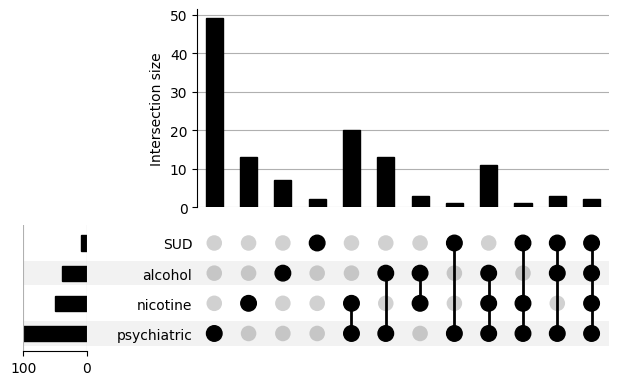

In [20]:
UpSet(gwascat, subset_size='count').plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_test_upset.svg')

# FUMA Gene to Function - integrate into network

## import datasets

In [93]:
#downloaded from FUMA- server
gtex54=pd.read_csv('input_files/FUMA_gene2func_fdr25_alcoholintake_network/gtex_v8_ts_DEG_annotatedsystem.txt', sep='\t')
gtex_meta=pd.read_csv('input_files/FUMA_gene2func_fdr25_alcoholintake_network/geneTable.txt', sep='\t')
gtex_meta.index=gtex_meta.ensg

In [94]:
gtex_dict=gtex_meta[['symbol']].to_dict

## format gtex 54 tissues output

In [95]:
gtex54_sig=gtex54[gtex54['adjP']<0.05]
twoside=gtex54_sig[gtex54_sig['Category']=='DEG.twoside']['GeneSet']
up=gtex54_sig[gtex54_sig['Category']=='DEG.up']['GeneSet']
down=gtex54_sig[gtex54_sig['Category']=='DEG.down']['GeneSet']
gtex54_sig=gtex54_sig[gtex54_sig['Category']=='DEG.twoside']
gtex54_sig['genes']=gtex54_sig['genes'].str.split(':')
gtex54_sig_exp=gtex54_sig.explode('genes')
gtex54_sig_exp=gtex54_sig_exp.merge(gtex_meta[['symbol']], left_on='genes', right_on='ensg',how='left')

In [96]:
print('list of tissues analyzed:')
set(gtex54_sig_exp['GeneSet'])

list of tissues analyzed:


{'Adrenal_Gland',
 'Bladder',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cerebellum',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Hippocampus',
 'Brain_Hypothalamus',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Putamen_basal_ganglia',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Substantia_nigra',
 'Cells_Cultured_fibroblasts',
 'Colon_Transverse',
 'Esophagus_Mucosa',
 'Heart_Atrial_Appendage',
 'Heart_Left_Ventricle',
 'Kidney_Cortex',
 'Liver',
 'Minor_Salivary_Gland',
 'Muscle_Skeletal',
 'Pancreas',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Small_Intestine_Terminal_Ileum',
 'Stomach',
 'Whole_Blood'}

In [97]:
# group gtex tissues into collapsed table- for adding info to network node descriptions
gtex54_sig_collapse=gtex54_sig_exp[['symbol','GeneSet','adjP']]
gtex54_sig_collapse=gtex54_sig_collapse.groupby('symbol').agg(tuple).applymap(list).reset_index()
gtex54_sig_collapse['N_GeneSet']=gtex54_sig_collapse['GeneSet'].apply(lambda x: len(x))
#make empty columns for all of the tissues set to false
gtex54_sig_collapse[list(range(3,len(twoside)+3))]=False
gtex54_sig_collapse.columns=['symbol','GeneSet','adjP','N_Geneset']+list(twoside)

#assign true/false for each tissue column for whether there is a significant enrichment in each tissue for each gene
for i in twoside:
    for j in range(len(gtex54_sig_collapse)):
        gtex54_sig_collapse[i].iloc[j] = i in gtex54_sig_collapse['GeneSet'][j]

/Users/brittanyleger/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Plot gene FUMA DEG- Fig 4A

In [98]:
twoside_tbl=gtex54[gtex54['Category']=='DEG.twoside']
twoside_tbl=twoside_tbl.sort_values("adjP", ascending=True)
#make a tissue dictionary to define a colour scheme
tiss_col_dict={'neuro':'#785EF0','gastro':'#FFB000','cardiac':'#D41A75', 'urinary':'#FFDF58','epidermal':'#6BABFF','other':'#FF7D2D', 'NS':"#CCCCCC",}
#assign colour to table
twoside_tbl['colour']=twoside_tbl['System'].apply(lambda x: tiss_col_dict.get(x))

In [27]:
plt.rcParams.update({'font.size': 10})

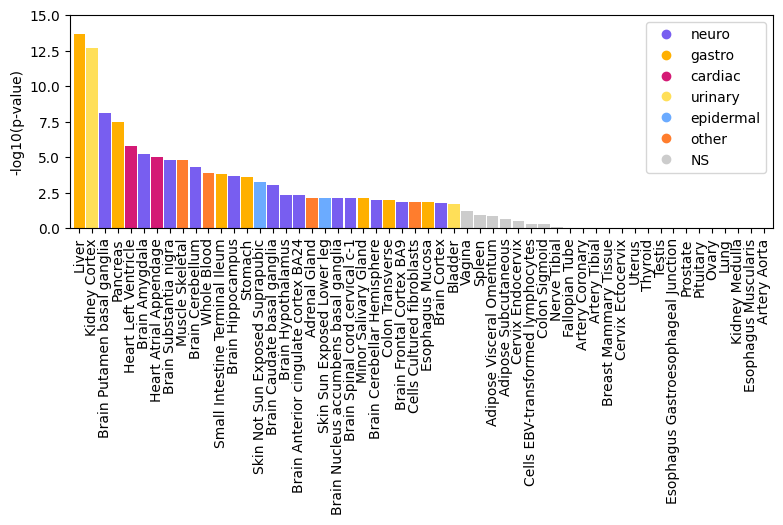

In [28]:
fig=plt.figure(figsize=(7.5,5))
fig=plt.bar(twoside_tbl['GeneSet'].str.replace('_',' '), -np.log10(twoside_tbl['adjP']), width=.9, align='center', color=twoside_tbl['colour'])
fig=plt.xticks(rotation=90)
fig=plt.ylabel('-log10(p-value)')
fig=plt.ylim([0,15])
fig=plt.tight_layout(pad=0)
fig=plt.margins(x=0.005)

# create legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in tiss_col_dict.values()]
plt.legend(markers, tiss_col_dict.keys(), numpoints=1)
if save_fig:
    plt.savefig('figures/' + 'gtex_enrichment_barplot_expanded.svg',bbox_inches='tight')

# import genebass PheWAS

In [99]:
#pvalue cutoffs used for alcohol consumption association with rare genes- based on FDR<0.25 cutoff
skato_cutoff=1.5e-4
burden_cutoff=1.1e-4
skat_cutoff=2.7e-5

In [100]:
tbl_nodes=pd.read_csv("input_files/combined_phewas.tsv",sep='\t')
tbl_nodes=tbl_nodes[(tbl_nodes['Pvalue']< skato_cutoff) | (tbl_nodes['Pvalue_Burden']<burden_cutoff) |(tbl_nodes['Pvalue_SKAT']<skat_cutoff)]
tbl_nodes=tbl_nodes.fillna("")
tbl_nodes['description']=tbl_nodes['description'].str.lower()
tbl_nodes_cond=tbl_nodes[['gene_symbol','description']].groupby('gene_symbol').agg(tuple).applymap(list).reset_index()
tbl_nodes_cond=pd.DataFrame({'gene_symbol':nodes}).merge(tbl_nodes_cond, on="gene_symbol", how="left")
tbl_nodes_cond=tbl_nodes_cond.fillna("")
tbl_nodes_cond.columns=['nodes','genebass_phewas']

# make dataframe for adding meta data to network

In [111]:
df=pd.DataFrame(nodes)
df.columns=['nodes']
#make columns for whether there are genes in the ACN that have been annotated for alcohol/ at all in GWAS catalog
df['in_gwas_catalog']=df['nodes'].isin(cat['GENE'])
df['alc_val']=df['nodes'].isin(cat_traits_ACN['alc']['GENE'])
#merge in annotation for catagories for gwas catalog
df=df.merge(t, left_on='nodes',right_on='GENE',how='left')
#merge in family names
df=df.merge(families,left_on='nodes',right_on='HGNC Symbol',how='left')
df=df.drop(['GENE'],axis=1)
#merge in gtex tissue enrichment
df=df.merge(gtex54_sig_collapse, left_on='nodes',right_on='symbol',how='left')
df=df.drop(['symbol'],axis=1)
df=df.merge(tbl_nodes_cond,on='nodes',how='left')
df

,nodes,in_gwas_catalog,alc_val,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT,HGNC Symbol,Approved name,family,...,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c-1,Brain_Substantia_nigra,Adrenal_Gland,Cells_Cultured_fibroblasts,Muscle_Skeletal,Whole_Blood,Bladder,Kidney_Cortex,genebass_phewas
0,STAM2,True,False,NaN,{smoking status measurement: smoking initiatio...,NaN,{intelligence: general cognitive ability (PMID...,NaN,NaN,NaN,...,True,False,True,False,True,True,True,False,False,"[operative procedures - main opcs4, non-cancer..."
1,SH3BP4,True,False,NaN,{unipolar depression: depression in smokers (P...,NaN,{memory performance: cognitive function (delay...,SH3BP4,SH3 domain binding protein 4,NaN,...,True,False,True,False,True,True,False,False,False,"[sleep duration (quantitative), operative proc..."
2,OTUD6B,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,True,False,True,"[operative procedures - main opcs4, operative ..."
3,RAD23A,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[mean corpuscular volume, mean corpuscular hae..."
4,HSP90AA1,True,True,"{nicotine use, generational effect measurement...",{smoking initiation: smoking initiation (PMID:...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[heel bone mineral density (bmd) (right), heel..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,APOC4,True,False,NaN,NaN,NaN,"{memory performance, language measurement: cog...",NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,"[operative procedures - main opcs4, operative ..."
204,ADH1C,True,True,{alcohol consumption measurement: alcohol cons...,NaN,{substance-related disorder: addiction risk fa...,"{sex interaction measurement, cerebral amyloid...",ADH1C,"alcohol dehydrogenase 1C (class I), gamma poly...",Alcohol Dehydrogenase,...,False,False,False,False,True,True,True,False,False,"[treatment/medication code, total bilirubin, n..."
205,KIF12,True,False,NaN,NaN,NaN,{cognitive decline measurement: rate of cognit...,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,True,"[treatment/medication code, operative procedur..."
206,LRRC37A2,True,False,NaN,NaN,NaN,{intelligence: general cognitive ability (PMID...,NaN,NaN,NaN,...,True,False,True,False,True,True,False,False,False,[date m20 first reported (acquired deformities...


In [112]:
df

,nodes,in_gwas_catalog,alc_val,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT,HGNC Symbol,Approved name,family,...,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c-1,Brain_Substantia_nigra,Adrenal_Gland,Cells_Cultured_fibroblasts,Muscle_Skeletal,Whole_Blood,Bladder,Kidney_Cortex,genebass_phewas
0,STAM2,True,False,NaN,{smoking status measurement: smoking initiatio...,NaN,{intelligence: general cognitive ability (PMID...,NaN,NaN,NaN,...,True,False,True,False,True,True,True,False,False,"[operative procedures - main opcs4, non-cancer..."
1,SH3BP4,True,False,NaN,{unipolar depression: depression in smokers (P...,NaN,{memory performance: cognitive function (delay...,SH3BP4,SH3 domain binding protein 4,NaN,...,True,False,True,False,True,True,False,False,False,"[sleep duration (quantitative), operative proc..."
2,OTUD6B,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,True,False,True,"[operative procedures - main opcs4, operative ..."
3,RAD23A,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[mean corpuscular volume, mean corpuscular hae..."
4,HSP90AA1,True,True,"{nicotine use, generational effect measurement...",{smoking initiation: smoking initiation (PMID:...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[heel bone mineral density (bmd) (right), heel..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,APOC4,True,False,NaN,NaN,NaN,"{memory performance, language measurement: cog...",NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,"[operative procedures - main opcs4, operative ..."
204,ADH1C,True,True,{alcohol consumption measurement: alcohol cons...,NaN,{substance-related disorder: addiction risk fa...,"{sex interaction measurement, cerebral amyloid...",ADH1C,"alcohol dehydrogenase 1C (class I), gamma poly...",Alcohol Dehydrogenase,...,False,False,False,False,True,True,True,False,False,"[treatment/medication code, total bilirubin, n..."
205,KIF12,True,False,NaN,NaN,NaN,{cognitive decline measurement: rate of cognit...,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,True,"[treatment/medication code, operative procedur..."
206,LRRC37A2,True,False,NaN,NaN,NaN,{intelligence: general cognitive ability (PMID...,NaN,NaN,NaN,...,True,False,True,False,True,True,False,False,False,[date m20 first reported (acquired deformities...


In [104]:
if save_file:
    df.to_csv('calculated_values/ACN_annotated_nodes.csv',index=False)

## make dataframe into dictionary and add node attributes to network

In [61]:
#necessary to replace NA to uploade to ndex
df=df.fillna('null')
df = df.astype(str)
#df.index=df['nodes']
df_dict=df.to_dict()
attributes=df.columns
attributes=attributes.drop('nodes')

In [62]:
#add attributes to network
for a in attributes:
    for i in network.nodes:
        network.set_node_attribute(node=i, attribute_name=a, type='string',values=df_dict[a][i])

# export network to ndex- source for Fig 3, Fig S4

In [ ]:
#check the attributes added to nodes
network.get_node_attributes(25)

In [ ]:
network.set_name(network.get_name()+'_annotated')
#use to upload as new newtwork with annotated subscript
if save_file:
    network.upload_to(server='public.ndexbio.org',
                      username=ndex_user,
                      password=ndex_password)

# check seed gene validation in GWAS catalog

## build tables and export

In [118]:
t

,GENE,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,A1CF,"{triglyceride measurement, alcohol consumption...",NaN,NaN,{cognitive function measurement: cognitive fun...
1,AADAT,{alcohol consumption measurement: alcohol cons...,NaN,NaN,NaN
2,AATF,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation (PMID:...,NaN,NaN
3,ABCA1,"{alcohol consumption measurement, high density...",{lung carcinoma: lung cancer in ever smokers (...,NaN,{alzheimer disease: alzheimer's disease (PMID:...
4,ABCA4,{aspartate aminotransferase measurement: aspar...,NaN,NaN,NaN
...,...,...,...,...,...
15483,other genes,NaN,NaN,NaN,"{bipolar disorder, schizophrenia: bipolar diso..."
15484,snoZ13_snr52,NaN,NaN,NaN,{unipolar depression: depression (PMID: 338593...
15485,snoZ6,NaN,NaN,NaN,"{alzheimer disease, family history of alzheime..."
15486,tcag7.1213,NaN,NaN,NaN,{exploratory eye movement measurement: explora...


In [148]:
rare_seed_df= seed_rare.merge(t,right_on='GENE',left_on='Gene Name',how='left')
rare_seed_df=rare_seed_df.drop('GENE',axis=1)

if save_file:
    rare_seed_df.to_csv("calculated_values/rare_seed_gene_catalog.csv",sep=",",index=False)

In [149]:
rare_seed_df

,Gene Name,Gene Id,P-Value SKATO,P-Value Burden,P-Value SKAT,BETA Burden,Burden Set,Chrom : Position,Chrom,Position,burden_FDR,skato_FDR,skat_FDR,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,MMEL1,ENSG00000142606,3.680000e-05,1.690000e-05,2.805640e-03,0.001404,missense|LC,1.002587e+09,1,2586658,1.218783e-01,1.851740e-01,5.553512e-01,{alcohol consumption measurement: drinks per w...,NaN,NaN,NaN
1,MTOR,ENSG00000198793,1.119600e-04,3.570000e-05,4.881025e-02,-0.018638,pLoF,1.011107e+09,1,11106515,1.490287e-01,2.425010e-01,7.791238e-01,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation (PMID:...,NaN,NaN
2,AC118553.2,ENSG00000283761,1.379400e-04,1.276000e-04,4.530800e-04,-0.005127,synonymous,1.099970e+09,1,99970489,2.661468e-01,2.427581e-01,4.476320e-01,NaN,NaN,NaN,NaN
3,KIF21B,ENSG00000116852,6.350000e-05,1.406000e-04,4.769200e-04,-0.014921,pLoF,1.200974e+09,1,200973806,2.730307e-01,2.156670e-01,4.476320e-01,NaN,{smoking initiation: smoking initiation (PMID:...,NaN,{schizophrenia: schizophrenia (PMID: 35396580)...
4,KDM5B,ENSG00000117139,4.340000e-05,2.250000e-05,1.012523e-02,-0.010240,pLoF,1.202729e+09,1,202728943,1.267093e-01,1.878924e-01,6.813484e-01,NaN,NaN,NaN,NaN
5,CHRM3,ENSG00000133019,6.250000e-05,5.240000e-05,1.137010e-03,-0.026184,pLoF,1.239907e+09,1,239907379,1.639658e-01,2.156670e-01,4.893474e-01,{aspartate aminotransferase measurement: aspar...,"{cleft palate, tobacco smoke exposure measurem...",{hallucinations: hallucinations in long-term c...,{schizophrenia: schizophrenia (PMID: 35396580)...
6,GCKR,ENSG00000084734,7.700000e-05,6.208300e-04,6.760000e-05,-0.001139,missense|LC,2.027492e+09,2,27492349,3.834424e-01,2.156670e-01,3.654019e-01,"{alcohol use disorder measurement, longitudina...",NaN,{substance-related disorder: addiction risk fa...,NaN
7,SCN7A,ENSG00000136546,2.270000e-05,5.111642e-02,1.080000e-05,0.000497,missense|LC,2.166406e+09,2,166405531,8.279038e-01,1.580621e-01,2.035862e-01,NaN,NaN,NaN,{cognitive behavioural therapy: response to co...
8,UBR3,ENSG00000144357,1.910000e-05,4.510000e-06,1.450049e-01,-0.022585,pLoF,2.169824e+09,2,169824452,5.078487e-02,1.539716e-01,8.581386e-01,NaN,NaN,NaN,NaN
9,FOXP1,ENSG00000114861,1.021400e-04,8.220000e-05,1.690500e-03,0.002416,missense|LC,3.070959e+09,3,70959160,2.012321e-01,2.300693e-01,5.091636e-01,{alcohol consumption measurement: alcohol cons...,{smoking status measurement: smoking initiatio...,{cannabis dependence: cannabis use disorder (P...,{schizophrenia: schizophrenia (PMID: 35396580)...


In [137]:
common_seed_df= seed_common.merge(t,left_on='GENE_NAME',right_on='GENE',how='left')
common_seed_df=common_seed_df.drop('GENE_y',axis=1)
common_seed_df=common_seed_df.rename(columns={'GENE_x':'GENE'})
if save_file:
    common_seed_df.to_csv("calculated_values/common_seed_geneGWAS_catalog.csv",sep=",",index=False)

In [136]:
common_seed_df.rename(columns={'GENE_x':'GENE'})


,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,GENE_NAME,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,79814,1,15561699,15595110,199,19,628831,4.9260,4.195900e-07,AGMAT,{alcoholic pancreatitis: alcoholic chronic pan...,NaN,NaN,NaN
1,84301,1,15607458,15671057,215,18,618929,5.5125,1.769100e-08,DDI2,{alcoholic pancreatitis: alcoholic chronic pan...,NaN,NaN,NaN
2,6248,1,15649869,15671722,63,10,625701,5.6159,9.774400e-09,RSC1A1,{alcoholic pancreatitis: alcoholic chronic pan...,NaN,NaN,NaN
3,23207,1,15674267,15744769,299,32,623320,6.6035,2.008100e-11,PLEKHM2,{alcohol consumption measurement: drinks per w...,NaN,NaN,NaN
4,127550,1,33296766,33331098,137,27,614472,4.6316,1.814100e-06,A3GALT2,NaN,NaN,NaN,{risk-taking behaviour: self-reported risk-tak...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,26291,19,48745559,48768330,115,32,616393,6.1094,5.000000e-10,FGF21,{alcohol consumption measurement: drinks per w...,NaN,NaN,NaN
290,92675,20,18577912,18773917,1107,41,626041,5.0186,2.602700e-07,DTD1,{alcohol consumption measurement: alcohol cons...,{smoking initiation: smoking initiation (PMID:...,NaN,"{anxiety: worry (PMID: 29942085), anxiety meas..."
291,84532,20,24996230,25068182,267,42,634326,5.0032,2.819800e-07,ACSS1,{bitter alcoholic beverage consumption measure...,NaN,NaN,{neuropsychological test: cognitive performanc...
292,116448,21,33060144,33082422,63,25,630584,4.6502,1.657900e-06,OLIG1,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation (PMID:...,NaN,NaN
